<a href="https://colab.research.google.com/github/gened1080/smoothing/blob/master/Smoothing_Sound_Filters.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Smoothing

In this notebook we will examine the effects of smoothing. Essentially, what we want to do is to take a volatile sequence with lots of spikes and make it look smooth. This can apply to any type of data that is represented as a sequence. Sound is one of them, but so is time series data! We will see that applying a moving average to sequences can be both useful for visually clarifying trends in COVID data and for clarifying sounds to our ears.

In [3]:
%%bash
!(stat -t /usr/local/lib/*/dist-packages/google/colab > /dev/null 2>&1) && exit 
rm -rf smoothing
git clone https://github.com/gened1080/smoothing.git

Cloning into 'smoothing'...


In [33]:
from __future__ import print_function, division

%matplotlib inline

import sys
sys.path.append("/content/smoothing/")

import os
if not os.path.exists('thinkdsp.py'):
    !wget https://github.com/AllenDowney/ThinkDSP/raw/master/code/thinkdsp.py

if not os.path.exists('thinkplot.py'):
    !wget https://github.com/AllenDowney/ThinkDSP/raw/master/code/thinkplot.py


import thinkdsp
import thinkplot
import numpy as np
from IPython.display import display
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from matplotlib import pyplot as plt
import numpy as np
import scipy.signal
import warnings
import pandas as pd
warnings.filterwarnings('ignore')

PI2 = 2 * np.pi

np.set_printoptions(precision=3, suppress=True)
%matplotlib inline

GRAY = '0.7'
# All the lines up to here are just setting up your environment

# Smoothing a time series of COVID 19 cases

We have taken daily data for confirmed COVID cases in the US from 1/22/2020 to 10/28/2020.

The data looks like this:

In [5]:
covid_data = pd.read_csv('/content/smoothing/covid_data.csv')
# remove missing data point
covid_data['date'] = pd.to_datetime(covid_data['date'])
dates = covid_data['date'][0:-1]
covid_data = covid_data['cases'][0:-1]

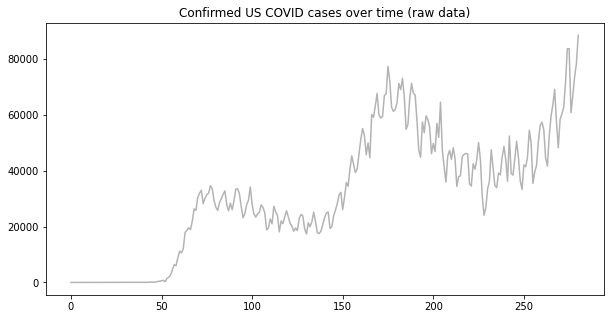

In [6]:
plt.figure(figsize=(10,5))
plt.plot(covid_data, color=GRAY)
plt.title('Confirmed US COVID cases over time (raw data)')
plt.show()

Now let's take a 30-day moving average of this sequence. What this means is we create a 30-point window and at each of the points in the sequence we compute the average of a window of 30 points around the original data point.

In [7]:
M = 30
window = np.ones(M)
window /= sum(window)
smoothed = np.convolve(covid_data, window, mode='valid')
days = np.array((dates - dates[0]) / np.timedelta64(1,'D'))
smoothed_days = days[M//2: len(smoothed) + M//2]

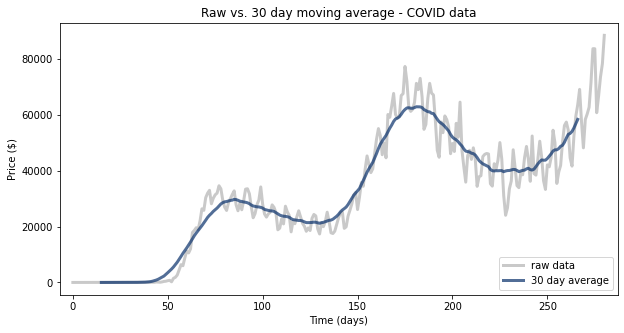

In [8]:
plt.figure(figsize=(10,5))
plt.title('Raw vs. 30 day moving average - COVID data')
thinkplot.plot(days, covid_data, color=GRAY, label='raw data')
thinkplot.plot(smoothed_days, smoothed, label='30 day average')

last = days[-1]
thinkplot.config(xlabel='Time (days)', 
                 ylabel='Price ($)',
                 xlim=[-7, last+7],
                 legend=True,
                 loc='lower right')

The smoothed graph of COVID cases is now a lot more visually clear as we have gotten rid of any smaller fluctuations each day and have now extracted the general trend of rising cases over a longer period of time.

Now let's see how we can apply the same principles to the auditory domain!

### Smoothing sound signals

Generate a 440 Hz sawtooth signal.

In [9]:
signal = thinkdsp.SawtoothSignal(freq=440)
wave = signal.make_wave(duration=1.0, framerate=44100)
wave.make_audio()

Plot the wave.

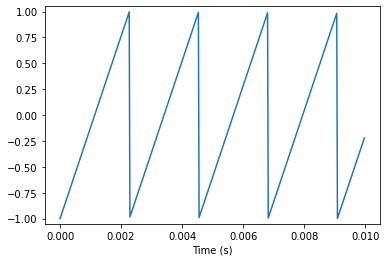

In [10]:
segment = wave.segment(duration=0.01)
segment.plot()
thinkplot.config(xlabel='Time (s)', ylim=[-1.05, 1.05])

Make a 'boxcar filter' window of 30 points. The boxcar filter (represented below) is just the weights that are multiplied to each data point in the 30-day window. In this case, each data point in a 30-day window gets a weight of 1/30 = 0.0333. 

Think of this like a 30-day moving average in the COVID data. This means that for every point in the wave form, we are going to take the moving average of 30 points around the original data point.



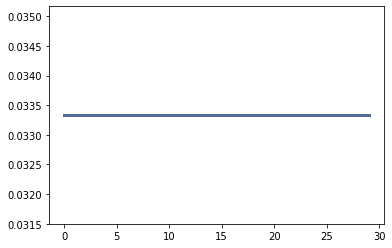

In [11]:
window = np.ones(30)
window /= sum(window)
thinkplot.plot(window)

Compute a convolution by rolling the window to the right. A convolution means to transform each point using a moving window. In this case, we are doing it with a box car filter through ```np.convolve```.

Plot the result of the convolution and the original. Notice that this exhibits the same behavior as the 30-day moving average COVID data where extreme values in the original data have now been lessened as evidenced by the smaller spikes.



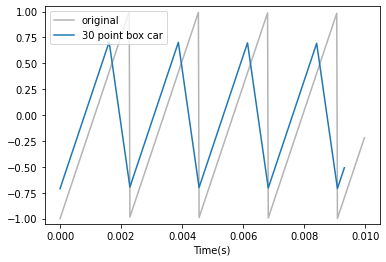

In [12]:
segment.plot(color=GRAY)
ys = np.convolve(segment.ys, window, mode='valid')
smooth2 = thinkdsp.Wave(ys, framerate=wave.framerate)
smooth2.plot()
plt.legend(['original', '30 point box car'])
thinkplot.config(xlabel='Time(s)', ylim=[-1.05, 1.05])

## Frequency domain

Let's see what's happening in the frequency domain. First, let's hear what the smoothed signal sounds like.

In [13]:
convolved = np.convolve(wave.ys, window, mode='same')
smooth = thinkdsp.Wave(convolved, framerate=wave.framerate)
smooth.make_audio()

Can you hear how this is different from the original? (play below) Which one gives you a 'smoother' listening experience?

In [14]:
wave.make_audio()

Plot spectrums of the original and smoothed waves:

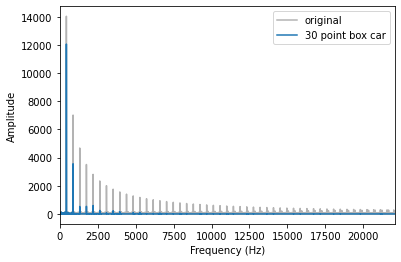

In [15]:
spectrum = wave.make_spectrum()
spectrum.plot(color=GRAY)

spectrum2 = smooth.make_spectrum()
spectrum2.plot()
plt.legend(['original', '30 point box car'])
thinkplot.config(xlabel='Frequency (Hz)',
                 ylabel='Amplitude',
                 xlim=[0, 22050])

For each harmonic, compute the ratio of the amplitudes before and after smoothing. We see that at higher frequencies we are significantly dampening the amplitude (low ratio) where as at lower frequencies, we are retaining close to the original amplitude (high ratio). In short, we are limiting the signal at higher frequencies more than in lower frequencies.

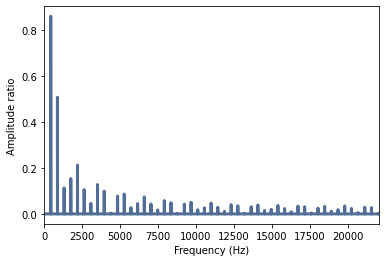

In [16]:
amps = spectrum.amps
amps2 = spectrum2.amps
ratio = amps2 / amps    
ratio[amps<280] = 0

thinkplot.plot(ratio)
thinkplot.config(xlabel='Frequency (Hz)',
                     ylabel='Amplitude ratio',
                     xlim=[0, 22050])

### Gaussian window

We just saw how a boxcar filter worked. Now, we can apply the same principles with something more sophisticated called a Gaussian window.

Make the boxcar window.

In [17]:
boxcar = np.ones(30)
boxcar /= sum(boxcar)

Make the Gaussian window.

In [34]:
gaussian = scipy.signal.gaussian(M=30, std=5)
gaussian /= sum(gaussian)

Plot the two windows. Do you notice something familiar about the shape of a Gaussian window?

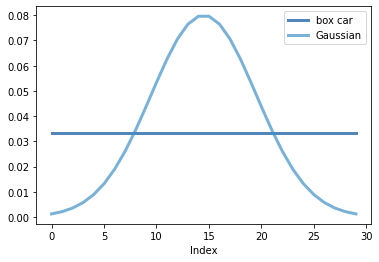

In [19]:
thinkplot.preplot(2)
thinkplot.plot(boxcar, label='box car')
thinkplot.plot(gaussian, label='Gaussian')
thinkplot.config(xlabel='Index',
                 loc='upper right')

A Gaussian distribution is just a fancy name for the normal distribution, so instead of taking an equally-weighted average of all 30 points in a window, we now use a normal distribution to determine the weights for each point in our window. Think of this as a weighted distribution where the original point (in the middle) gets the highest weight, while points further away from the orignial get lower weight.

Convolve the square wave with the Gaussian window.

In [20]:
ys = np.convolve(wave.ys, gaussian, mode='same')
smooth_gauss = thinkdsp.Wave(ys, framerate=wave.framerate)
spectrum2 = smooth_gauss.make_spectrum()

Plot the new wave with the original.

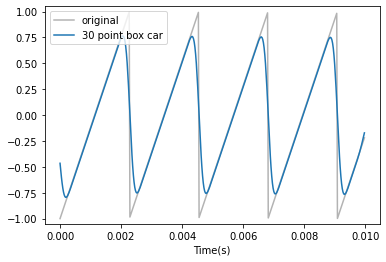

In [21]:
segment.plot(color=GRAY)
ys = np.convolve(segment.ys, gaussian, mode='same')
smooth2 = thinkdsp.Wave(ys, framerate=wave.framerate)
smooth2.plot()
plt.legend(['original', '30 point box car'])
thinkplot.config(xlabel='Time(s)', ylim=[-1.05, 1.05])

Let's play this.

In [22]:
smooth_gauss.make_audio()

Compare this to the boxcar.

In [23]:
smooth.make_audio()

Comparae this to the original.

In [24]:
wave.make_audio()

Compute the ratio of the amplitudes.

In [25]:
amps = spectrum.amps
amps2 = spectrum2.amps
ratio = amps2 / amps   
ratio[amps<560] = 0

Plot the amplitude ratio between the original and the gaussian filtered signal.

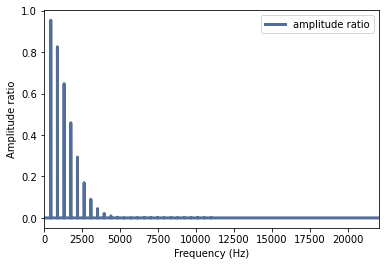

In [26]:
thinkplot.plot(ratio, label='amplitude ratio')

thinkplot.config(xlabel='Frequency (Hz)',
                 ylabel='Amplitude ratio',
                 xlim=[0, 22050])

# Interactive

* Play with different parameters for boxcar filters
* Play with different parameters for Gaussian filters

In [27]:
def plot_gauss_filter(M=30, std=5):
    signal = thinkdsp.SquareSignal(freq=440)
    wave = signal.make_wave(duration=1, framerate=44100)
    spectrum = wave.make_spectrum()

    gaussian = scipy.signal.gaussian(M=M, std=std)
    gaussian /= sum(gaussian)
    high = gaussian.max()
    
    thinkplot.preplot(cols=2)
    ys = np.convolve(segment.ys, gaussian, mode='same')
    smooth_segment = thinkdsp.Wave(ys, framerate=wave.framerate)
    plt.title('Original vs. Filtered Wave')
    segment.plot()
    smooth_segment.plot()
    plt.legend(['Original', 'Gaussian'])

    ys = np.convolve(wave.ys, gaussian, mode='same')
    smooth = thinkdsp.Wave(ys, framerate=wave.framerate)
    spectrum2 = smooth.make_spectrum()

    # plot the ratio of the original and smoothed spectrum
    amps = spectrum.amps
    amps2 = spectrum2.amps
    ratio = amps2 / amps    
    ratio[amps<560] = 0

    thinkplot.subplot(2)
    plt.title('Amplitude ratio between original and filtered')
    thinkplot.plot(ratio)

    thinkplot.config(xlabel='Frequency (Hz)',
                     ylabel='Amplitude ratio',
                     xlim=[0, 22050],
                     ylim=[0, 1.05])

def plot_boxcar_filter(win=30):
    window = np.ones(win)
    window /= sum(window)

    convolved = np.convolve(wave.ys, window, mode='same')
    smooth = thinkdsp.Wave(convolved, framerate=wave.framerate)
    spectrum2 = smooth.make_spectrum()

    # plot
    thinkplot.preplot(cols=2)
    ys = np.convolve(segment.ys, window, mode='same')
    smooth_segment = thinkdsp.Wave(ys, framerate=wave.framerate)
    plt.title('Original vs. Filtered Wave')
    segment.plot()
    smooth_segment.plot()
    plt.legend(['Original', 'Boxcar'])

    # plot the ratio of the original and smoothed spectrum
    amps = spectrum.amps
    amps2 = spectrum2.amps
    ratio = amps2 / amps    
    ratio[amps<560] = 0

    thinkplot.subplot(2)
    plt.title('Amplitude ratio between original and filtered')
    thinkplot.plot(ratio)

    thinkplot.config(xlabel='Frequency (Hz)',
                     ylabel='Amplitude ratio',
                     xlim=[0, 22050],
                     ylim=[0, 1.05])

def create_gauss_audio(M=30, std=5):
    signal = thinkdsp.SquareSignal(freq=440)
    wave = signal.make_wave(duration=1, framerate=44100)
    spectrum = wave.make_spectrum()

    gaussian = scipy.signal.gaussian(M=M, std=std)
    gaussian /= sum(gaussian)
    high = gaussian.max()

    ys = np.convolve(wave.ys, gaussian, mode='same')
    smooth = thinkdsp.Wave(ys, framerate=wave.framerate)
    return smooth.make_audio()

def create_boxcar_audio(win=30):
    signal = thinkdsp.SquareSignal(freq=440)
    wave = signal.make_wave(duration=1, framerate=44100)

    window = np.ones(win)
    window /= sum(window)

    convolved = np.convolve(wave.ys, window, mode='same')
    smooth = thinkdsp.Wave(convolved, framerate=wave.framerate)

    return smooth.make_audio()
  

## Original

Here's the original sawtooth wave for reference.

In [28]:
# play the original wave
spectrum = wave.make_spectrum()
wave.make_audio()

## Box car filter
Try out different values of window size

In [29]:
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

slider = widgets.IntSlider(min=2, max=100, value=30)
interact(plot_boxcar_filter, win=slider);

interactive(children=(IntSlider(value=30, description='win', min=2), Output()), _dom_classes=('widget-interact…

In [30]:
# audio for boxcar filter
audio = create_boxcar_audio(win=30)
audio

## Guassian Filters
Try out different values of `M` (window) and `std` (spread).

In [31]:
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

slider = widgets.IntSlider(min=2, max=100, value=30)
slider2 = widgets.FloatSlider(min=0, max=20, value=5)
interact(plot_gauss_filter, M=slider, std=slider2);

interactive(children=(IntSlider(value=30, description='M', min=2), FloatSlider(value=5.0, description='std', m…

In [32]:
# audio for Gaussian filter
audio = create_gauss_audio(M=30, std=5)
audio